In [40]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

imdb = pd.read_csv(path+'/IMDB Dataset.csv')

Path to dataset files: /Users/jaesolshin/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [42]:
import functools
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pnpxai import AutoExplanationForTextClassification
from pnpxai.explainers.utils.postprocess import minmax

from helpers import (
    get_imdb_dataset,
    get_bert_model,
    get_bert_tokenizer,
    bert_collate_fn,
)

In [47]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "mps" if torch.backends.mps.is_available() else "cpu"

# device = torch.device('cpu')
model = get_bert_model(model_name='fabriceyhc/bert-base-uncased-imdb', num_labels=2)
model.to(device)

dataset = get_imdb_dataset(split='test')
tokenizer = get_bert_tokenizer(model_name='fabriceyhc/bert-base-uncased-imdb')
loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=functools.partial(bert_collate_fn, tokenizer=tokenizer),
)
input_extractor = lambda batch: tuple(inp.to(device) for inp in batch[0])
forward_arg_extractor = lambda inputs: inputs[0]
additional_forward_arg_extractor = lambda inputs: inputs[1:]
label_extractor = lambda batch: batch[-1].to(device)
target_extractor = lambda outputs: outputs.argmax(-1).to(device)


# auto explanation
expr = AutoExplanationForTextClassification(
    model=model,
    data=loader,
    layer=model.bert.embeddings.word_embeddings,
    mask_token_id=tokenizer.mask_token_id,
    input_extractor=input_extractor,
    label_extractor=label_extractor,
    target_extractor=target_extractor,
    forward_arg_extractor=forward_arg_extractor,
    additional_forward_arg_extractor=additional_forward_arg_extractor,
)


# explain and evaluate
results = expr.run_batch(
    data_ids=range(4),
    explainer_id=0,
    postprocessor_id=0,
    metric_id=1,
)

In [48]:
#------------------------------------------------------------------------------#
#------------------------------- optimization ---------------------------------#
#------------------------------------------------------------------------------#

data_id = 3176
explainer_id = 2 # KernelShap
metric_id = 1 # ABPC

optimized = expr.optimize(
    data_ids=data_id,
    explainer_id=explainer_id,
    metric_id=metric_id,
    direction='maximize', # less is better
    sampler='random', # Literal['tpe','random']
    n_trials=50, # by default, 50 for sampler in ['random', 'tpe'], None for ['grid']
    seed=42, # seed for sampler: by default, None
)

print('Best/Explainer:', optimized.explainer) # get the optimized explainer
print('Best/PostProcessor:', optimized.postprocessor) # get the optimized postprocessor
print('Best/value:', optimized.study.best_trial.value) # get the optimized value

# Every trial in study has its explainer and postprocessor in user attr.
i = 25
print(f'{i}th Trial/Explainer', optimized.study.trials[i].user_attrs['explainer']) # get the explainer of i-th trial
print(f'{i}th Trial/PostProcessor', optimized.study.trials[i].user_attrs['postprocessor']) # get the postprocessor of i-th trial
print(f'{i}th Trial/value', optimized.study.trials[i].value)

# For example, you can use optuna's API to get the explainer and postprocessor of the worst trial
def get_worst_trial(study):
    valid_trials = [trial for trial in study.trials if trial.value is not None]
    return sorted(valid_trials, key=lambda trial: trial.value)[0]

worst_trial = get_worst_trial(optimized.study)
print('Worst/Explainer:', worst_trial.user_attrs['explainer'])
print('Worst/PostProcessor', worst_trial.user_attrs['postprocessor'])
print('Worst/value', worst_trial.value)


[I 2024-12-04 22:49:37,243] A new study created in memory with name: no-name-91969d62-201d-47c7-98d4-009254d96744
[I 2024-12-04 22:49:40,956] Trial 0 finished with value: 0.8991753458976746 and parameters: {'explainer.n_steps': 40, 'explainer.baseline_fn.method': 'token', 'postprocessor.pooling_fn.method': 'sumpos', 'postprocessor.normalization_fn.method': 'minmax'}. Best is trial 0 with value: 0.8991753458976746.
[I 2024-12-04 22:49:43,436] Trial 1 finished with value: 0.8973339796066284 and parameters: {'explainer.n_steps': 30, 'explainer.baseline_fn.method': 'token', 'postprocessor.pooling_fn.method': 'possum', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 0 with value: 0.8991753458976746.
[I 2024-12-04 22:49:46,067] Trial 2 finished with value: 0.8988070487976074 and parameters: {'explainer.n_steps': 20, 'explainer.baseline_fn.method': 'token', 'postprocessor.pooling_fn.method': 'posmaxnorm', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 

Best/Explainer: IntegratedGradients(layer=Embedding(30522, 768, padding_idx=0), n_steps=10, baseline_fn=TokenBaselineFunction(token_id=103))
Best/PostProcessor: PostProcessor(pooling_fn=SumPos(channel_dim=-1), normalization_fn=Identity())
Best/value: 0.8992389440536499
25th Trial/Explainer IntegratedGradients(layer=Embedding(30522, 768, padding_idx=0), n_steps=80, baseline_fn=TokenBaselineFunction(token_id=103))
25th Trial/PostProcessor PostProcessor(pooling_fn=L2NormSquare(channel_dim=-1), normalization_fn=MinMax())
25th Trial/value 0.7968035340309143
Worst/Explainer: IntegratedGradients(layer=Embedding(30522, 768, padding_idx=0), n_steps=80, baseline_fn=TokenBaselineFunction(token_id=103))
Worst/PostProcessor PostProcessor(pooling_fn=L1Norm(channel_dim=-1), normalization_fn=Identity())
Worst/value 0.6989380121231079


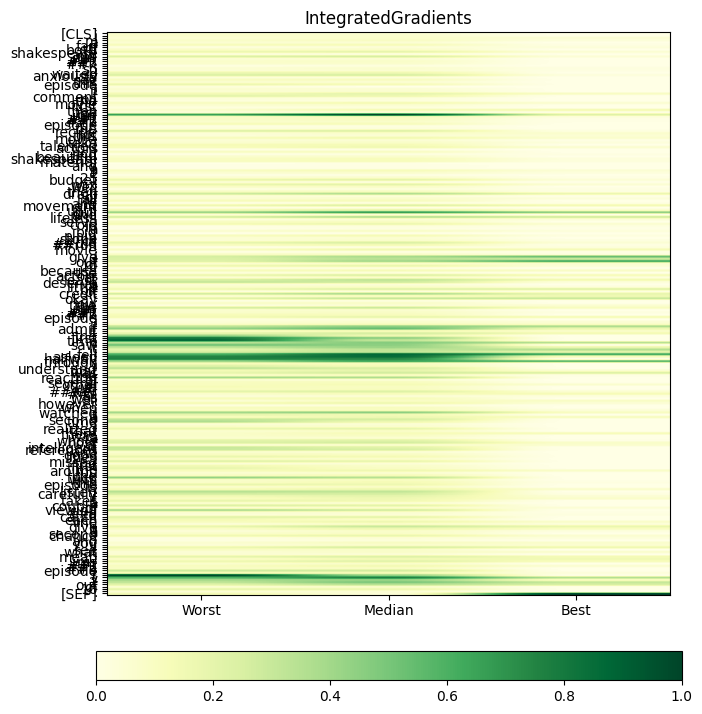

In [49]:

# ------------------------------------------------------------------------------#
# ------------------------------- visualization --------------------------------#
# ------------------------------------------------------------------------------#

data = expr.manager.batch_data_by_ids([data_id])
inputs = expr.input_extractor(data)
labels = expr.label_extractor(data)

# prepare trials to visualize
sorted_trials = sorted(
    [trial for trial in optimized.study.trials if trial.value is not None],
    key=lambda trial: trial.value,
)
trials_to_vis = {
    'Worst': sorted_trials[0],
    'Median': sorted_trials[len(sorted_trials)//2],
    'Best': sorted_trials[-1],
}

ylabs = [tokenizer.decode(token) for token in inputs[0].squeeze()]
xlabs = trials_to_vis.keys()
data = []
for trial in trials_to_vis.values():
    attrs = trial.user_attrs['explainer'].attribute(inputs, labels)
    postprocessed = trial.user_attrs['postprocessor'](attrs)
    data.append(minmax(postprocessed))
data = torch.cat(data).transpose(1, 0).detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
hm = ax.imshow(data, cmap='YlGn')
fig.colorbar(hm, ax=ax, location='bottom')
ax.set_xticks(range(len(xlabs)), labels=xlabs)
ax.set_yticks(range(len(ylabs)), labels=ylabs)
ax.set_aspect(len(xlabs)/len(ylabs))
ax.set_title(expr.manager.get_explainer_by_id(explainer_id).__class__.__name__)
fig.savefig('auto_explanation_imdb_example.png')


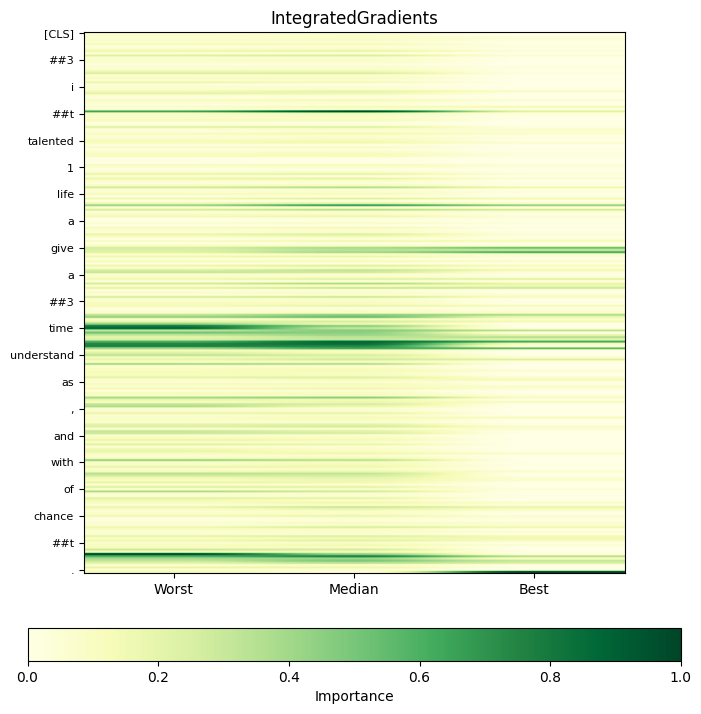

In [51]:
# 일부만 표시
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
hm = ax.imshow(data, cmap='YlGn')
fig.colorbar(hm, ax=ax, location='bottom', label='Importance')

# 라벨 간격 조정
step = max(len(ylabs) // 20, 1)  # 최대 20개의 라벨 표시
ax.set_yticks(range(0, len(ylabs), step))
ax.set_yticklabels([ylabs[i] for i in range(0, len(ylabs), step)], fontsize=8)

# X축 라벨
ax.set_xticks(range(len(xlabs)), labels=xlabs)
ax.set_aspect(len(xlabs) / len(ylabs))
ax.set_title(expr.manager.get_explainer_by_id(explainer_id).__class__.__name__)
fig.savefig('auto_explanation_imdb_example.png', dpi=300)